# PRML : Polynomial Curve Fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import unicode_literals, print_function
import six
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
sys.version

'3.6.0 |Anaconda 4.3.0 (x86_64)| (default, Dec 23 2016, 13:19:00) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## generate sample dataset

In [3]:
def make_truth_data(func=lambda x: x):
    xs = np.linspace(0, 1, num=50, endpoint=True)
    ts = func(xs)
    return xs, ts

def make_observed_data(func=lambda x: x, std=0.1):
    xs = np.linspace(0, 1, num=10, endpoint=True)
    ts = func(xs) + np.random.normal(0, std, xs.size)
    return xs, ts

def sin(x):
    return np.sin(2*np.pi*x)

#def step(x):
#    return 1.0 if x >= 0.5 and x <= 1.0 else 0.0

xs_truth, ts_truth = make_truth_data(np.vectorize(sin))
xs_observ, ts_observ = make_observed_data(np.vectorize(sin), std=0.2)

In [4]:
def plot_sample(ax, xs_truth, ys_truth, xs_observ, ts_observ):
    ax.plot(xs_truth, ts_truth, label='truth')
    ax.scatter(xs_observ, ts_observ, color='green', marker='o', label='observation')
    ax.set_xlim(np.min(xs_truth), np.max(xs_truth))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.legend()
    return ax

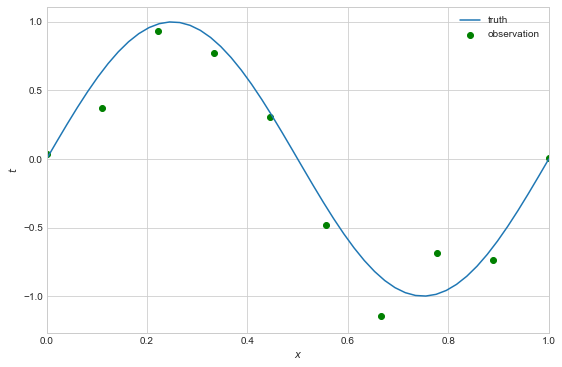

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)

## design matrix

ここでの基底関数は $\phi_{i}(x) = x^{i}$ とする

In [6]:
def poly_features(xs, m=1):
    # formula (3.16)
    return np.asarray([np.power(xs, i) for i in six.moves.range(m+1)]).transpose()

In [7]:
poly_features(xs_observ, m=3)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.11111111,  0.01234568,  0.00137174],
       [ 1.        ,  0.22222222,  0.04938272,  0.01097394],
       [ 1.        ,  0.33333333,  0.11111111,  0.03703704],
       [ 1.        ,  0.44444444,  0.19753086,  0.0877915 ],
       [ 1.        ,  0.55555556,  0.30864198,  0.17146776],
       [ 1.        ,  0.66666667,  0.44444444,  0.2962963 ],
       [ 1.        ,  0.77777778,  0.60493827,  0.47050754],
       [ 1.        ,  0.88888889,  0.79012346,  0.70233196],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [8]:
def plot_prediction(ax, ys_pred, ys_std):
    ax.plot(xs_truth, ys_pred, color='red', label='mean of predictive distribution')
    ax.fill_between(xs_truth, ys_pred-ys_std, ys_pred+ys_std,
                      color='pink', alpha=0.5, label='standard diviation of predictive distribution')
    ax.legend()
    return ax

## maximum likelihood estimation

In [9]:
class MaximumLikelihoodRegression():
    def __init__(self, basis_function=lambda x: x, m=1):
        self.basis_function = basis_function
        self.m = m
        
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.34) or (3.15)
        self.w_ml = np.linalg.inv(phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.21)
        self.std_ml = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_ml), 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_ml)
        return ys, self.std_ml

ys =  [-0.07924822  0.10688117  0.269534    0.40972101  0.52845295  0.62674055
  0.70559458  0.76602576  0.80904485  0.8356626   0.84688974  0.84373703
  0.8272152   0.79833501  0.7581072   0.70754251  0.64765169  0.57944549
  0.50393464  0.42212991  0.33504202  0.24368173  0.14905978  0.05218691
 -0.04592612 -0.14426857 -0.24182971 -0.33759877 -0.43056502 -0.51971771
 -0.6040461  -0.68253944 -0.75418699 -0.817978   -0.87290172 -0.91794741
 -0.95210433 -0.97436173 -0.98370886 -0.97913498 -0.95962934 -0.9241812
 -0.87177982 -0.80141444 -0.71207432 -0.60274873 -0.4724269  -0.3200981
 -0.14475158  0.0546234 ]
std =  0.0921816023267


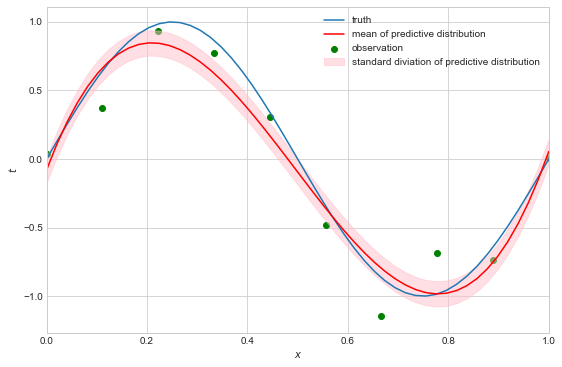

In [10]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きすぎるとover fittingが発生
- 分散も非常に小さい (high bias)

ys =  [ 0.03450768 -0.01331212 -0.00554036  0.05930598  0.16992783  0.3092284
  0.45908755  0.60337681  0.72960967  0.82956992  0.89921101  0.93807397
  0.94842821  0.93430017  0.90051837  0.85187006  0.79243512  0.72513554
  0.65151568  0.57174804  0.48484201  0.3890192   0.28220834  0.16260493
  0.0292368  -0.11752472 -0.27556583 -0.44079639 -0.60712543 -0.76667839
 -0.91027399 -1.02816013 -1.11098705 -1.15097153 -1.14317805 -1.08681201
 -0.98638595 -0.85258228 -0.70259561 -0.55969404 -0.45169156 -0.40797395
 -0.45466683 -0.6074782  -0.86168785 -1.17869318 -1.46845476 -1.56711543
 -1.20899432  0.00791871]
std =  7.5374474257e-09


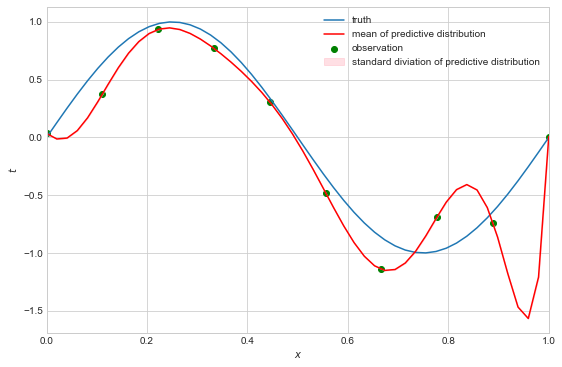

In [11]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=9)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## maximum posterior estimation

結果としては正則化最小二乗法 (§3.1.4) と同様らしいのでその通り実装 (これで合っている?)

In [12]:
class MaximumPosteriorRegression():
    def __init__(self, basis_function=lambda x: x, m=1, lmd=1):
        self.basis_function = basis_function
        self.m = m
        self.lmd = lmd
    
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.28)
        self.w_map = np.linalg.inv(self.lmd * np.identity(phis.shape[1]) + phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.29) or (1.67)
        self.std_map = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_map), 2)) \
                            + (self.lmd/2.) * np.sum(np.power(self.w_map, 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_map)
        return ys, self.std_map

ys =  [ 0.21967772  0.31925284  0.40438172  0.47570112  0.53384777  0.57945844
  0.61316985  0.63561877  0.64744193  0.64927608  0.64175797  0.62552435
  0.60121196  0.56945755  0.53089786  0.48616964  0.43590965  0.38075462
  0.3213413   0.25830643  0.19228678  0.12391907  0.05384006 -0.0173135
 -0.08890488 -0.16029732 -0.23085407 -0.29993839 -0.36691353 -0.43114276
 -0.49198931 -0.54881644 -0.60098741 -0.64786547 -0.68881388 -0.72319588
 -0.75037473 -0.76971369 -0.780576   -0.78232493 -0.77432372 -0.75593562
 -0.7265239  -0.6854518  -0.63208258 -0.56577949 -0.48590579 -0.39182472
 -0.28289955 -0.15849352]
std =  0.427668211277


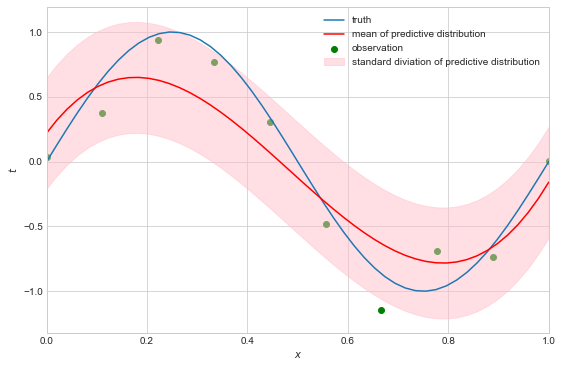

In [13]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=3, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きくても事前分布(≒正則化)の導入でover fittingを防ぐことができる
- ただし，ベイズ推定のようにパラメータの事後分布を求めている訳ではないので，outlierに弱い場合があるらしい
  - http://ibisforest.org/index.php?MAP推定

ys =  [ 0.10567447  0.20660476  0.29886007  0.38223488  0.45653724  0.52159141
  0.57724092  0.62335182  0.65981629  0.68655652  0.70352885  0.7107282
  0.70819278  0.69600895  0.67431631  0.64331292  0.60326055  0.55448996
  0.49740607  0.4324929   0.36031829  0.28153806  0.1968997   0.10724518
  0.01351295 -0.08326135 -0.18194538 -0.28131234 -0.38004501 -0.47674196
 -0.56992628 -0.65805706 -0.73954408 -0.81276605 -0.87609283 -0.92791205
 -0.96666064 -0.99086176 -0.99916757 -0.99040864 -0.96365025 -0.91825654
 -0.85396298 -0.77095788 -0.66997375 -0.55238917 -0.4203421  -0.27685533
 -0.12597515  0.02707611]
std =  0.147549004867


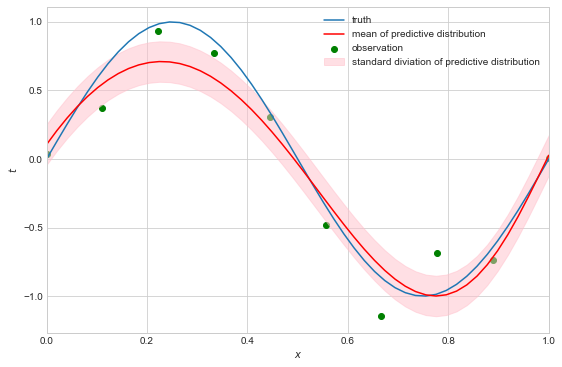

In [14]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=9, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## bayesian inference

In [15]:
class BayesianRegression():
    def __init__(self, basis_function=lambda x: x, m=1, alpha=1., beta=1.):
        self.basis_function = basis_function
        self.m = m
        self.alpha = alpha
        self.beta = beta

    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.53) or (1.72)
        var_inv = self.alpha * np.identity(phis.shape[1]) + self.beta * phis.T.dot(phis)
        self.var = np.linalg.inv(var_inv) 
        # formula (3.54) or (1.70)
        self.mean = self.beta * self.var.dot(phis.T.dot(ts))

    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.58)
        pred_mean = phis.dot(self.mean)
        # formula (3.59)
        pred_var = (1./self.beta) + np.sum(phis.dot(self.var.dot(phis.T)), axis=1)
        pred_std = np.sqrt(pred_var)
        return pred_mean, pred_std

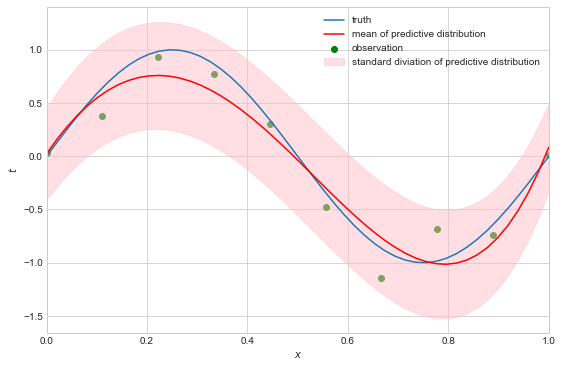

In [16]:
model = BayesianRegression(basis_function=poly_features, m=4, alpha=5e-3, beta=25)
model.fit(xs_observ, ts_observ)
pred_mean, pred_std = model.predict(xs_truth)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, pred_mean, pred_std)